In [7]:
%pip install unsupervised_absa

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement unsupervised_absa (from versions: none)
ERROR: No matching distribution found for unsupervised_absa


# Overall Pipeline

1. Diagram
2. Explaination of the pipeline

# Dataset sample

### Data loading

In this section, any dataset can be used. Including dataset that doesn't have any aspect terms or categories, and dataset that doesn't have polarity. For this example, we will used an existing dataset for aspect based sentiment analysis called semeval2014 task 4 which include aspect terms and categories analysis.

In [1]:
# Load dataset from huggingface
from datasets import load_dataset
train_dataset = load_dataset("Yaxin/SemEval2014Task4Raw", split='train')
validation_dataset = load_dataset("Yaxin/SemEval2014Task4Raw", split='validation')
test_dataset = load_dataset("Yaxin/SemEval2014Task4Raw", split='test')

c:\Users\User\anaconda3\envs\absa\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No config specified, defaulting to: sem_eval2014_task4_raw/All
Found cached dataset sem_eval2014_task4_raw (C:/Users/User/.cache/huggingface/datasets/Yaxin___sem_eval2014_task4_raw/All/0.0.1/3f2b4b42aa35876b7faba99ae6f73b106955b8c9162c6fc5160fd74497f7790f)
No config specified, defaulting to: sem_eval2014_task4_raw/All
Found cached dataset sem_eval2014_task4_raw (C:/Users/User/.cache/huggingface/datasets/Yaxin___sem_eval2014_task4_raw/All/0.0.1/3f2b4b42aa35876b7faba99ae6f73b106955b8c9162c6fc5160fd74497f7790f)
No config specified, defaulting to: sem_eval2014_task4_raw/All
Found cached dataset sem_eval2014_task4_raw (C:/Users/User/.cache/huggingface/datasets/Yaxin___sem_eval2014_task4_raw/All/0.0.1/3f2b4b42aa35876b7faba99ae6f73b106955b8

The test dataset doesn't have any polarity but it does have terms and categories.

# Preprocessing

Next will be preprocessing the data. In this sample, most of the text dataset are pretty cleaned. But for the sake of this demo, we will clean it anyways.

In [3]:
from unsupervised_absa.preprocess import simple_preprocessing
from datasets import Dataset

In [4]:
# preprocessing currently only supports pandas.series, list, and numpy
train_df = train_dataset.to_pandas()
train_df['text'] = simple_preprocessing(train_df['text'])
preprocessed_dataset = Dataset.from_pandas(train_df)

Processing strip_spaces: 100%|██████████| 11/11 [00:00<00:00, 35.63it/s]         


The processes in the preprocessing pipeline include:
1. encode decode
2. convert_unicode
3. remove_url
4. remove_control_characters
5. remove_tags
6. remove_emoji
7. convert_contractions
8. remove_numbers
9. remove_punctuation
10. remove_multiple_spaces
11. strip_spaces

# Pos Tagging

The purpose of pos tagging to get the potential aspect terms in each sentence. For sentences without aspects being detect will be directed to the sentence embedding extraction section.
The pos tagging model used here is from [Flair](https://github.com/flairNLP/flair), a library to perform NLP processing. This project revolves around using this library.

In [9]:
from unsupervised_absa.tagger import Tagger
tagger = Tagger('pos', device='cuda')
preprocessed_df = preprocessed_dataset.to_pandas()
preprocessed_df['pos_tag'] = tagger.tagging(preprocessed_df['text'], filter_tags=["NN", "NNS"])

2023-04-12 00:43:39,608 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD


2023-04-12 00:43:39.723 | INFO     | unsupervised_absa.tagger:__init__:32 - Tagger model instantiated with device: cpu
2023-04-12 00:43:39.738 | INFO     | unsupervised_absa.tagger:tagging:38 - Extracting pos tags
100%|██████████| 6086/6086 [32:17<00:00,  3.14it/s] 


In [ ]:
# save postag results in a json file: list of dictionaries
import json
pos_tags = preprocessed_df.drop(columns=['aspectTerms', 'aspectCategories', 'domain']).to_dict('records')
with open("data/semeval_pos_tag.json", "w") as fp:
    json.dump(pos_tags, fp) 

Performing these pos tags for nouns will give us the candidate terms. 

100%|██████████| 6086/6086 [00:00<00:00, 1737681.02it/s]


<Axes: title={'center': 'Top k Most Frequent Words'}>

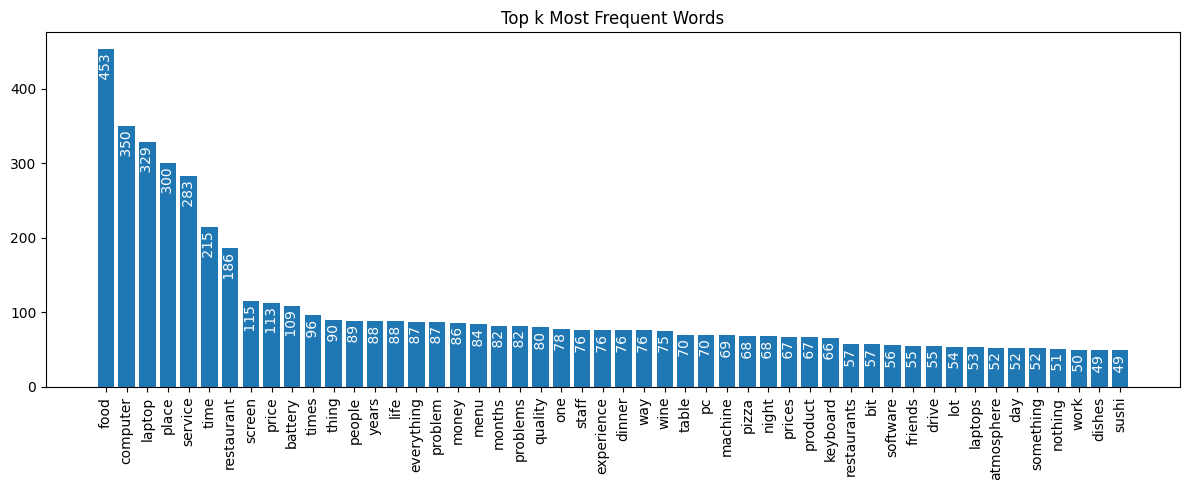

In [55]:
from tqdm import tqdm
from unsupervised_absa.preprocess import plot_top_k_words
import json

with open('data/semeval_pos_tag.json') as f:
    pos_tags = json.load(f)

list_of_words = []
for row in tqdm(pos_tags):
    for pos_data in row['pos_tag']:
        list_of_words.append(pos_data['word'])
plot_top_k_words(list_of_words, 50)

Remove words that has length less than 2

In [56]:
# filter tags with less than 3 letter
# save postag results in a json file: list of dictionaries
for row in tqdm(pos_tags):
    new_pos = []
    for pos_data in row['pos_tag']:
        if len(pos_data['word']) >= 3:
            new_pos.append(pos_data)
    row['pos_tag'] = new_pos

100%|██████████| 6086/6086 [00:00<00:00, 1216070.42it/s]


In [57]:
with open("data/semeval_pos_tag_filtered.json", "w") as fp:
    json.dump(pos_tags, fp)

In [58]:
import json
with open('data/semeval_pos_tag_filtered.json') as f:
    pos_tags = json.load(f)

list_of_words = []
for row in tqdm(pos_tags):
    for pos_data in row['pos_tag']:
        list_of_words.append(pos_data['word'])

100%|██████████| 6086/6086 [00:00<00:00, 1520250.98it/s]


# Extract Embeddings

This section is used to extract the word embeddings of each nouns that are tagged from pos tagging process. These terms will be clustered to get the specific domain they are in.

In [59]:
# get the list of words, remove all the 
# convert words to lower case
list_of_words = list(set(map(lambda x: x.lower(), list_of_words)))

### Word Embedding

### Bert base

In [16]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
bert_embedding = ExtractEmbedding(ModelType.TRANSFORMER_WORD, 'bert-base-uncased')

c:\Users\User\anaconda3\envs\absa\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
2023-04-12 01:17:17.281 | INFO     | unsupervised_absa.embedding:__init__:80 - Tagger model instantiated with device: cpu


In [17]:
bert_embedding_data = bert_embedding.extract(list_of_words)

100%|██████████| 3906/3906 [01:50<00:00, 35.42it/s]


In [18]:
import numpy as np
np.save('data/sem_eval_bert_embedding.npy', bert_embedding_data)

### Deberta-v3-Large

In [61]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
deberta_embedding = ExtractEmbedding(ModelType.TRANSFORMER_WORD, 'microsoft/deberta-v3-large')

c:\Users\User\anaconda3\envs\absa\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\User\anaconda3\envs\absa\lib\site-packages\transformers\convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that

In [62]:
deberta_embedding_data = deberta_embedding.extract(list_of_words)

100%|██████████| 3906/3906 [40:58<00:00,  1.59it/s]


In [63]:
import numpy as np
np.save('data/sem_eval_deberta_embedding.npy', deberta_embedding_data)

### Glove

In [19]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
glove_embedding = ExtractEmbedding(ModelType.WORD, 'glove')

2023-04-12 01:19:09,978 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to C:\Users\User\AppData\Local\Temp\tmpnnxgh_7l


100%|██████████| 153M/153M [01:17<00:00, 2.06MB/s]   

2023-04-12 01:20:28,812 copying C:\Users\User\AppData\Local\Temp\tmpnnxgh_7l to cache at C:\Users\User\.flair\embeddings\glove.gensim.vectors.npy
2023-04-12 01:20:28,877 removing temp file C:\Users\User\AppData\Local\Temp\tmpnnxgh_7l


2023-04-12 01:20:29,880 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to C:\Users\User\AppData\Local\Temp\tmplnrgveum


100%|██████████| 20.5M/20.5M [00:09<00:00, 2.32MB/s]

2023-04-12 01:20:40,112 copying C:\Users\User\AppData\Local\Temp\tmplnrgveum to cache at C:\Users\User\.flair\embeddings\glove.gensim
2023-04-12 01:20:40,124 removing temp file C:\Users\User\AppData\Local\Temp\tmplnrgveum



2023-04-12 01:20:42.990 | INFO     | unsupervised_absa.embedding:__init__:80 - Tagger model instantiated with device: cpu


In [20]:
glove_embedding_data = glove_embedding.extract(list_of_words)

100%|██████████| 3906/3906 [00:00<00:00, 6581.18it/s]


In [21]:
import numpy as np
np.save('data/sem_eval_glove_embedding.npy', glove_embedding_data)

### FastText

In [22]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
fast_text_embedding = ExtractEmbedding(ModelType.WORD, 'en')

2023-04-12 01:20:44,752 https://flair.informatik.hu-berlin.de/resources/embeddings/token/en-fasttext-news-300d-1M.vectors.npy not found in cache, downloading to C:\Users\User\AppData\Local\Temp\tmpg2zlc2s9


100%|██████████| 1.12G/1.12G [05:03<00:00, 3.95MB/s]   

2023-04-12 01:25:49,389 copying C:\Users\User\AppData\Local\Temp\tmpg2zlc2s9 to cache at C:\Users\User\.flair\embeddings\en-fasttext-news-300d-1M.vectors.npy


2023-04-12 01:25:49,981 removing temp file C:\Users\User\AppData\Local\Temp\tmpg2zlc2s9
2023-04-12 01:25:51,580 https://flair.informatik.hu-berlin.de/resources/embeddings/token/en-fasttext-news-300d-1M not found in cache, downloading to C:\Users\User\AppData\Local\Temp\tmpvpm8m0bi


100%|██████████| 52.1M/52.1M [00:21<00:00, 2.49MB/s]

2023-04-12 01:26:14,552 copying C:\Users\User\AppData\Local\Temp\tmpvpm8m0bi to cache at C:\Users\User\.flair\embeddings\en-fasttext-news-300d-1M
2023-04-12 01:26:14,577 removing temp file C:\Users\User\AppData\Local\Temp\tmpvpm8m0bi



2023-04-12 01:26:22.660 | INFO     | unsupervised_absa.embedding:__init__:80 - Tagger model instantiated with device: cpu


In [23]:
fast_text_embedding_data = fast_text_embedding.extract(list_of_words)

100%|██████████| 3906/3906 [00:00<00:00, 6131.42it/s]


In [24]:
import numpy as np
np.save('data/sem_eval_fast_text_embedding.npy', fast_text_embedding_data)

### Word2Vec

Word2Vec is not in flair, what we can do is convert from gensim to flair

#### Using Word2Vec pretrained on google news

In [25]:
import gensim.downloader
model_path = gensim.downloader.load('word2vec-google-news-300', return_path=True)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [26]:
# load the model to keyedvector and save it as keyedvector
vectors = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)
vectors.save('models/word2vec-google.gensim', pickle_protocol=4)

In [27]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
word2vec_embedding = ExtractEmbedding(ModelType.WORD, 'models/word2vec-google.gensim')

2023-04-12 01:31:59.238 | INFO     | unsupervised_absa.embedding:__init__:80 - Tagger model instantiated with device: cpu


In [28]:
word2vec_embedding_data = word2vec_embedding.extract(list_of_words)

100%|██████████| 3906/3906 [00:00<00:00, 5189.69it/s]


In [29]:
import numpy as np
np.save('data/sem_eval_word2vec_embedding.npy', word2vec_embedding_data)

### Stacked Embedding

Stacked embedding of the embedding models [bert, glove, FastText, Word2Vec]

In [68]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
stacked_embedding = ExtractEmbedding([ModelType.TRANSFORMER_WORD, ModelType.TRANSFORMER_WORD, ModelType.WORD, ModelType.WORD, ModelType.WORD], ['microsoft/deberta-v3-large', 'bert-base-uncased', 'glove', 'en', 'models/word2vec-google.gensim'])

c:\Users\User\anaconda3\envs\absa\lib\site-packages\transformers\convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
2023-04-12 21:25:44.316 | INFO     | unsupervised_absa.embedding:__init__:80 - Tagger model instantiated with device: cpu


In [69]:
stacked_embedding_data = stacked_embedding.extract(list_of_words)

100%|██████████| 3906/3906 [41:06<00:00,  1.58it/s]


In [70]:
import numpy as np
np.save('data/sem_eval_stacked_embedding.npy', stacked_embedding_data)

### sup-promcse-roberta-large word embedding

In [73]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
promcse_embedding = ExtractEmbedding(ModelType.TRANSFORMER_DOC, 'YuxinJiang/sup-promcse-roberta-large')

2023-04-12 22:14:13.602 | INFO     | unsupervised_absa.embedding:__init__:80 - Tagger model instantiated with device: cpu


In [74]:
promcse_embedding_data = promcse_embedding.extract(list_of_words)

100%|██████████| 3906/3906 [06:19<00:00, 10.29it/s]


In [75]:
import numpy as np
np.save('data/promcse_word_embedding.npy', promcse_embedding_data)

### sup-simcse-roberta-large word embedding

In [76]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
simcse_embedding = ExtractEmbedding(ModelType.TRANSFORMER_DOC, 'princeton-nlp/sup-simcse-roberta-large')

2023-04-12 22:20:40.110 | INFO     | unsupervised_absa.embedding:__init__:80 - Tagger model instantiated with device: cpu


In [77]:
simcse_embedding_data = simcse_embedding.extract(list_of_words)

100%|██████████| 3906/3906 [06:01<00:00, 10.81it/s]


In [78]:
import numpy as np
np.save('data/simcse_word_embedding.npy', simcse_embedding_data)

### all-MiniLM-L6-v2

In [79]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
all_MiniLM_L6_v2_embedding = ExtractEmbedding(ModelType.TRANSFORMER_DOC, 'sentence-transformers/all-MiniLM-L6-v2')

2023-04-12 22:26:43.150 | INFO     | unsupervised_absa.embedding:__init__:80 - Tagger model instantiated with device: cpu


In [80]:
all_MiniLM_L6_v2_embedding_data = all_MiniLM_L6_v2_embedding.extract(list_of_words)

100%|██████████| 3906/3906 [00:23<00:00, 164.26it/s]


In [81]:
import numpy as np
np.save('data/all_MiniLM_L6_v2_word_embedding.npy', all_MiniLM_L6_v2_embedding_data)

### Sentence Embedding

In [59]:
# get the sentences
preprocessed_df = preprocessed_dataset.to_pandas()
preprocessed_df = preprocessed_df.drop_duplicates(subset=['text'])

### sup-promcse-roberta-large

In [60]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
promcse_embedding = ExtractEmbedding(ModelType.TRANSFORMER_DOC, 'YuxinJiang/sup-promcse-roberta-large')

2023-04-12 13:28:07.020 | INFO     | unsupervised_absa.embedding:__init__:80 - Tagger model instantiated with device: cpu


In [61]:
promcse_embedding_data = promcse_embedding.extract(preprocessed_df['text'])

100%|██████████| 6055/6055 [17:53<00:00,  5.64it/s]


In [62]:
import numpy as np
np.save('data/promcse_embedding.npy', promcse_embedding_data)

### sup-simcse-roberta-large

In [63]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
simcse_embedding = ExtractEmbedding(ModelType.TRANSFORMER_DOC, 'princeton-nlp/sup-simcse-roberta-large')

2023-04-12 13:46:04.884 | INFO     | unsupervised_absa.embedding:__init__:80 - Tagger model instantiated with device: cpu


In [64]:
simcse_embedding_data = simcse_embedding.extract(preprocessed_df['text'])

100%|██████████| 6055/6055 [18:21<00:00,  5.50it/s]  


In [65]:
import numpy as np
np.save('data/simcse_embedding.npy', simcse_embedding_data)

### all-MiniLM-L6-v2

In [66]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
all_MiniLM_L6_v2_embedding = ExtractEmbedding(ModelType.TRANSFORMER_DOC, 'sentence-transformers/all-MiniLM-L6-v2')

2023-04-12 14:04:28.041 | INFO     | unsupervised_absa.embedding:__init__:80 - Tagger model instantiated with device: cpu


In [67]:
all_MiniLM_L6_v2_embedding_data = all_MiniLM_L6_v2_embedding.extract(preprocessed_df['text'])

100%|██████████| 6055/6055 [01:10<00:00, 86.18it/s]


In [68]:
import numpy as np
np.save('data/all_MiniLM_L6_v2_embedding.npy', all_MiniLM_L6_v2_embedding_data)

### Stacked Sentence Embedding

Stacked embedding of the embedding models [sup-promcse-roberta-large, princeton-nlp/sup-simcse-roberta-large, sentence-transformers/all-MiniLM-L6-v2]

In [69]:
from unsupervised_absa.embedding import ExtractEmbedding, ModelType
stacked_sentence_embedding = ExtractEmbedding([ModelType.TRANSFORMER_DOC, ModelType.TRANSFORMER_DOC, ModelType.TRANSFORMER_DOC], ['YuxinJiang/sup-promcse-roberta-large', 'princeton-nlp/sup-simcse-roberta-large', 'sentence-transformers/all-MiniLM-L6-v2'])

2023-04-12 14:05:47.821 | INFO     | unsupervised_absa.embedding:__init__:80 - Tagger model instantiated with device: cpu


In [70]:
stacked_sentence_embedding_data = stacked_sentence_embedding.extract(preprocessed_df['text'])

100%|██████████| 6055/6055 [37:26<00:00,  2.70it/s]


In [71]:
import numpy as np
np.save('data/stacked_sentence_embedding.npy', stacked_sentence_embedding_data)

# Clustering

In [1]:
from unsupervised_absa.clustering import ClusteringModel
from sklearn.cluster import KMeans

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

def get_best_cluster(embedding, start_k, end_k):
    results = []
    for k in range(start_k, end_k + 1):
        km = KMeans(k, n_init=10, max_iter=1000, tol=1e-04, random_state=42)
        cluster = ClusteringModel(km)
        # convert embedding data to cosine similarity
        result = cluster.fit(embedding, cosine_distance=False)
        result["n_cluster"] = k
        results.append(result)
    return pd.DataFrame.from_dict(results).reset_index(drop=True)

def plot_result(df, n_cluster_variable_name):
    clusters = df[n_cluster_variable_name]
    fig, ax = plt.subplots(nrows=1, ncols=len(df.columns) - 1, figsize=(15, 5))
    fig.tight_layout()
    columns = list(df.columns)
    columns.remove(n_cluster_variable_name)
    for (idx, column) in enumerate(columns):
        ax[idx].plot(clusters, df[column],'bx-')
        ax[idx].set_xlabel('cluster k value') 
        ax[idx].set_ylabel(f'{column}') 
        ax[idx].set_title(f'{column} analysis')
    

### Word Embedding Clustering

Bert

2023-04-12 20:07:22.056 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 20:07:22.641 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 20:07:23.394 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 20:07:24.325 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=5, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 20:07:25.384 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 20:07:26.517 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=10

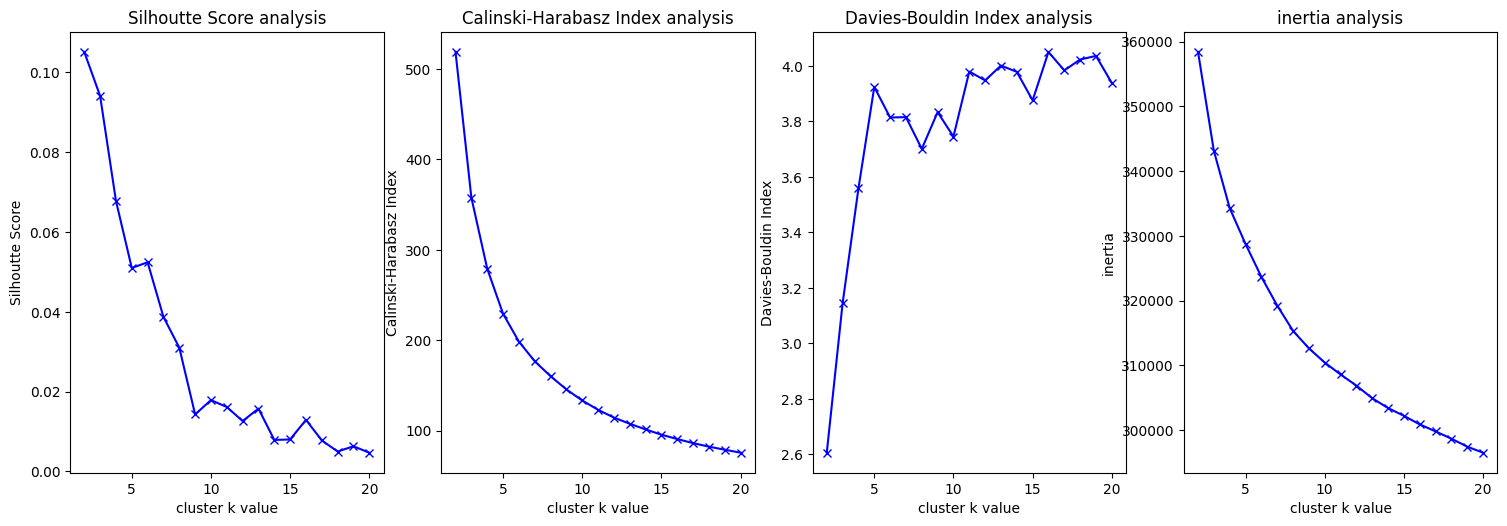

In [45]:
import numpy as np
bert_embedding = np.load('data/sem_eval_bert_embedding.npy', allow_pickle=True).item()
np_bert_embedding = np.stack(list(bert_embedding.values()), axis=0)
cluster_result = get_best_cluster(np_bert_embedding, 2, 20)
plot_result(cluster_result, "n_cluster")

Deberta

2023-04-12 21:22:17.629 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:22:18.345 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:22:19.383 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:22:20.490 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=5, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:22:21.713 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:22:23.224 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=10

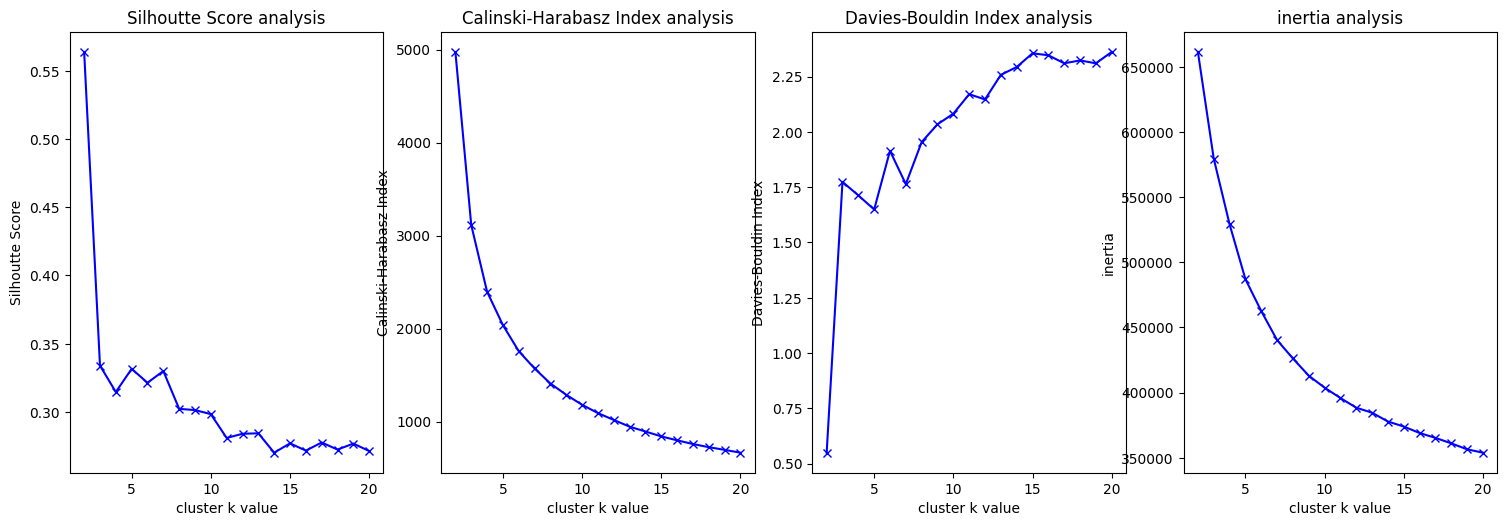

In [64]:
import numpy as np
deberta_embedding = np.load('data/sem_eval_deberta_embedding.npy', allow_pickle=True).item()
np_deberta_embedding = np.stack(list(deberta_embedding.values()), axis=0)
cluster_result = get_best_cluster(np_deberta_embedding, 2, 20)
plot_result(cluster_result, "n_cluster")

Glove

2023-04-12 21:22:59.589 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:22:59.832 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:23:00.100 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:23:00.392 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=5, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:23:00.697 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:23:01.036 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=10

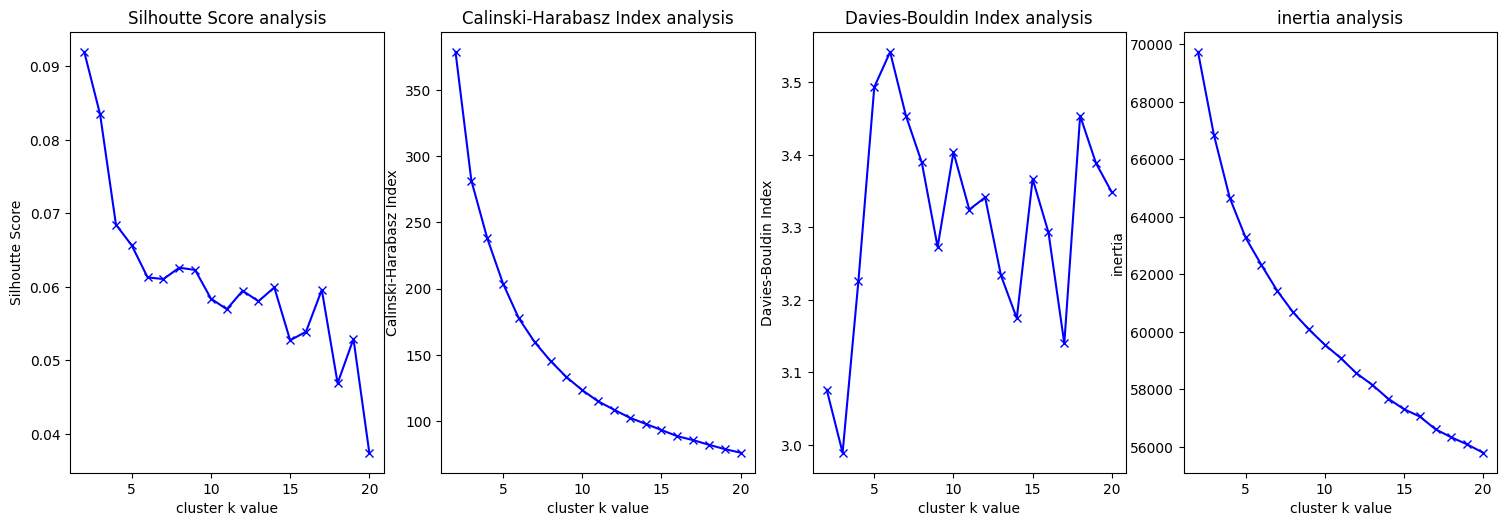

In [65]:
import numpy as np
glove_embedding = np.load('data/sem_eval_glove_embedding.npy', allow_pickle=True).item()
np_glove_embedding = np.stack(list(glove_embedding.values()), axis=0)
cluster_result = get_best_cluster(np_glove_embedding, 2, 20)
plot_result(cluster_result, "n_cluster")

FastText

2023-04-12 21:23:07.751 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:23:08.160 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:23:08.628 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:23:09.162 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=5, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:23:09.768 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:23:10.406 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=10

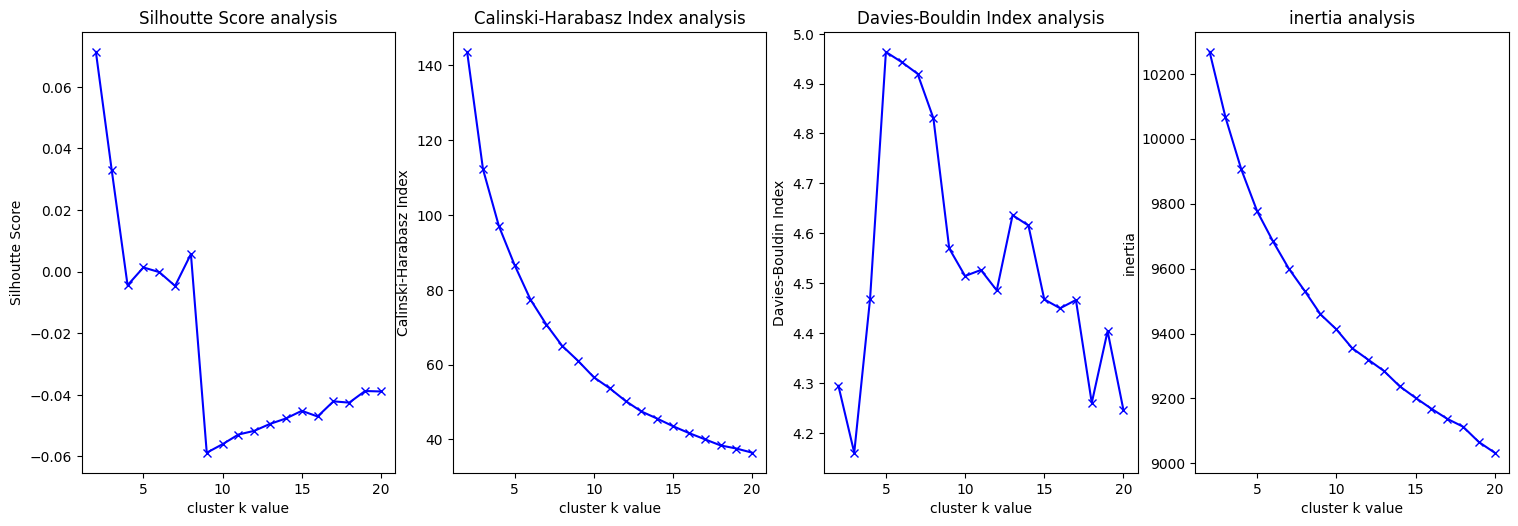

In [66]:
import numpy as np
fast_text_embedding = np.load('data/sem_eval_fast_text_embedding.npy', allow_pickle=True).item()
np_fast_text_embedding = np.stack(list(fast_text_embedding.values()), axis=0)
cluster_result = get_best_cluster(np_fast_text_embedding, 2, 20)
plot_result(cluster_result, "n_cluster")

Word2Vec

2023-04-12 21:23:25.402 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:23:25.773 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:23:26.282 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:23:26.776 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=5, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:23:27.389 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 21:23:28.047 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=10

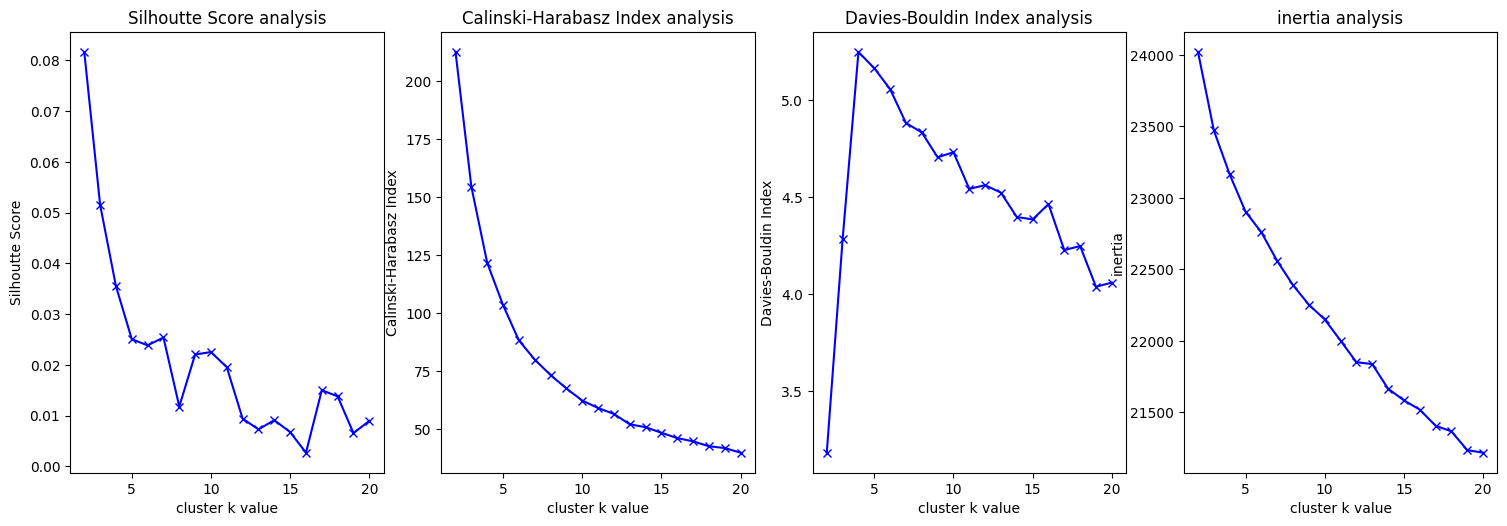

In [67]:
import numpy as np
word2vec_embedding = np.load('data/sem_eval_word2vec_embedding.npy', allow_pickle=True).item()
np_word2vec_embedding = np.stack(list(word2vec_embedding.values()), axis=0)
cluster_result = get_best_cluster(np_word2vec_embedding, 2, 20)
plot_result(cluster_result, "n_cluster")

Stacked Embedding

2023-04-12 22:06:51.309 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:06:52.860 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:06:55.044 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:06:58.192 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=5, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:07:01.623 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:07:04.793 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=10

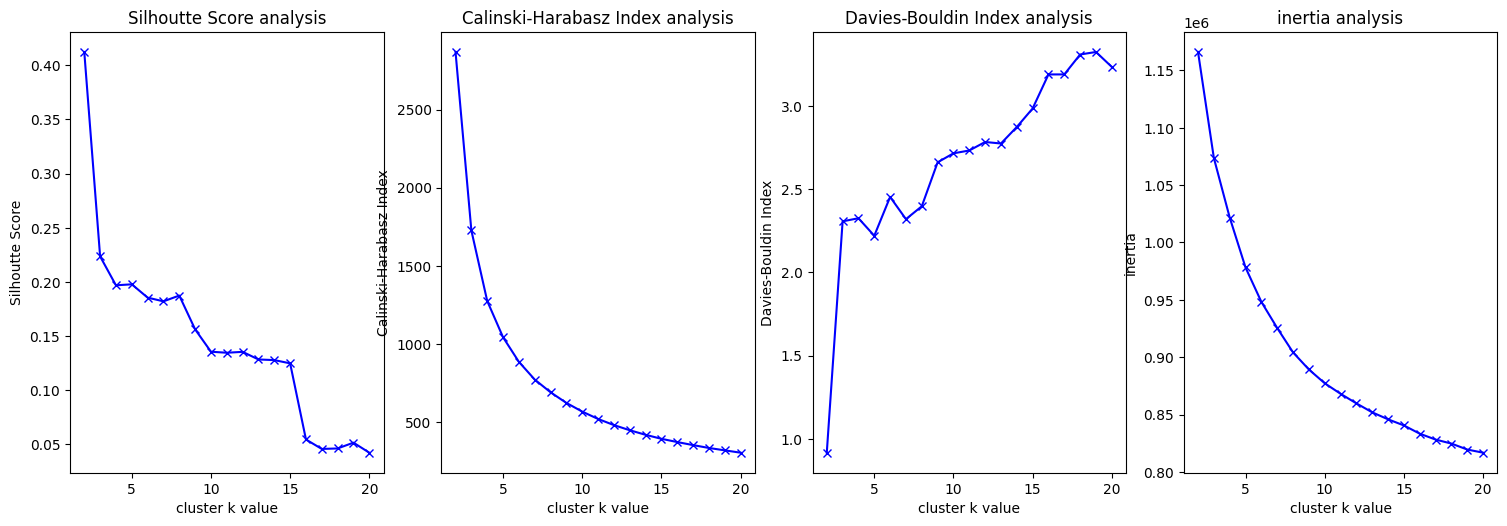

In [71]:
import numpy as np
stacked_embedding = np.load('data/sem_eval_stacked_embedding.npy', allow_pickle=True).item()
np_stacked_embedding = np.stack(list(stacked_embedding.values()), axis=0)
cluster_result = get_best_cluster(np_stacked_embedding, 2, 20)
plot_result(cluster_result, "n_cluster")

2023-04-12 22:29:08.912 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:29:09.302 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:29:09.789 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:29:10.368 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=5, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:29:11.031 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:29:11.730 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=10

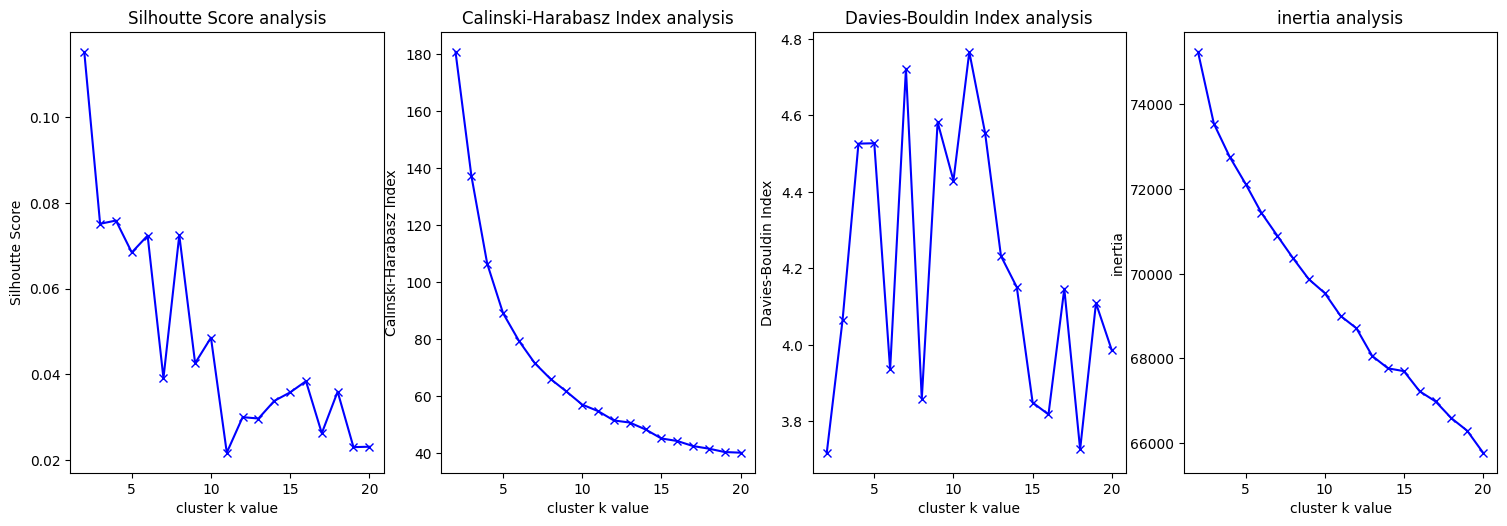

In [83]:
import numpy as np
all_MiniLM_L6_v2_word_embedding = np.load('data/all_MiniLM_L6_v2_word_embedding.npy', allow_pickle=True).item()
np_all_MiniLM_L6_v2_word_embedding = np.stack(list(all_MiniLM_L6_v2_word_embedding.values()), axis=0)
cluster_result = get_best_cluster(np_all_MiniLM_L6_v2_word_embedding, 2, 20)
plot_result(cluster_result, "n_cluster")

2023-04-12 22:29:49.709 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:29:50.371 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:29:51.269 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:29:52.476 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=5, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:29:53.807 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:29:55.332 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=10

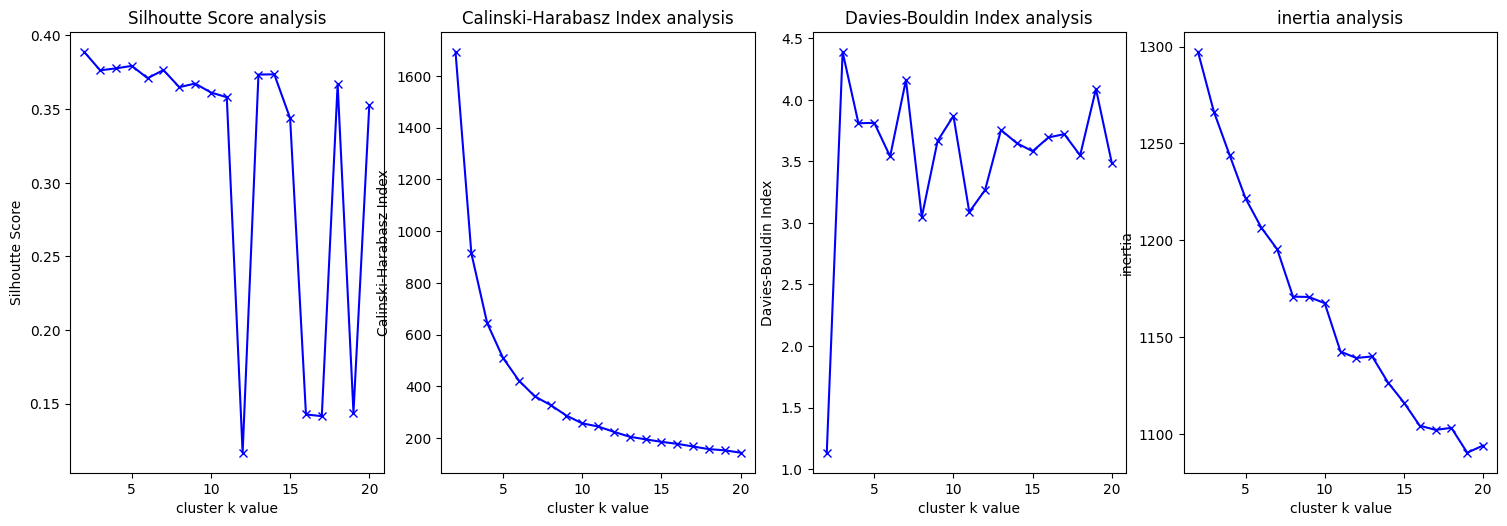

In [84]:
import numpy as np
promcse_word_embedding = np.load('data/promcse_word_embedding.npy', allow_pickle=True).item()
np_promcse_word_embedding = np.stack(list(promcse_word_embedding.values()), axis=0)
cluster_result = get_best_cluster(np_promcse_word_embedding, 2, 20)
plot_result(cluster_result, "n_cluster")

2023-04-12 22:30:31.061 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:30:31.878 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:30:32.828 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:30:34.025 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=5, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:30:35.470 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=42) with 3906 Datapoints.
2023-04-12 22:30:37.203 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=10

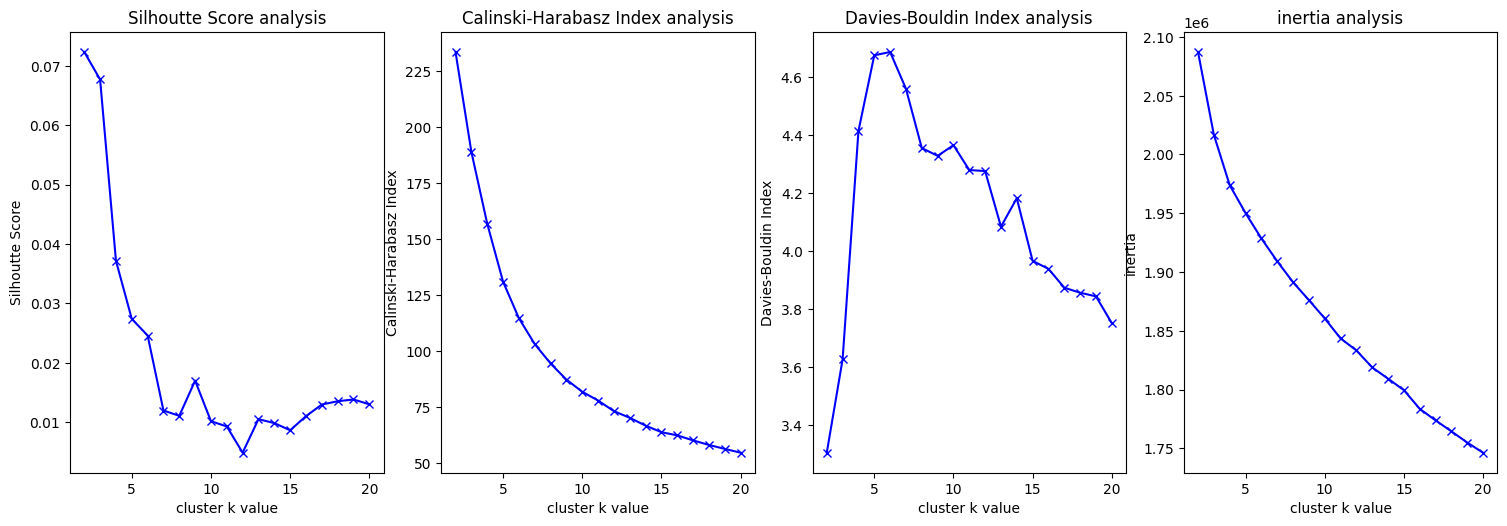

In [85]:
import numpy as np
simcse_word_embedding = np.load('data/simcse_word_embedding.npy', allow_pickle=True).item()
np_simcse_word_embedding = np.stack(list(simcse_word_embedding.values()), axis=0)
cluster_result = get_best_cluster(np_simcse_word_embedding, 2, 20)
plot_result(cluster_result, "n_cluster")

### Sentence Embedding Clustering

2023-04-12 22:36:07.602 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:36:08.370 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:36:09.319 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:36:10.393 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=5, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:36:11.554 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:36:12.811 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=10

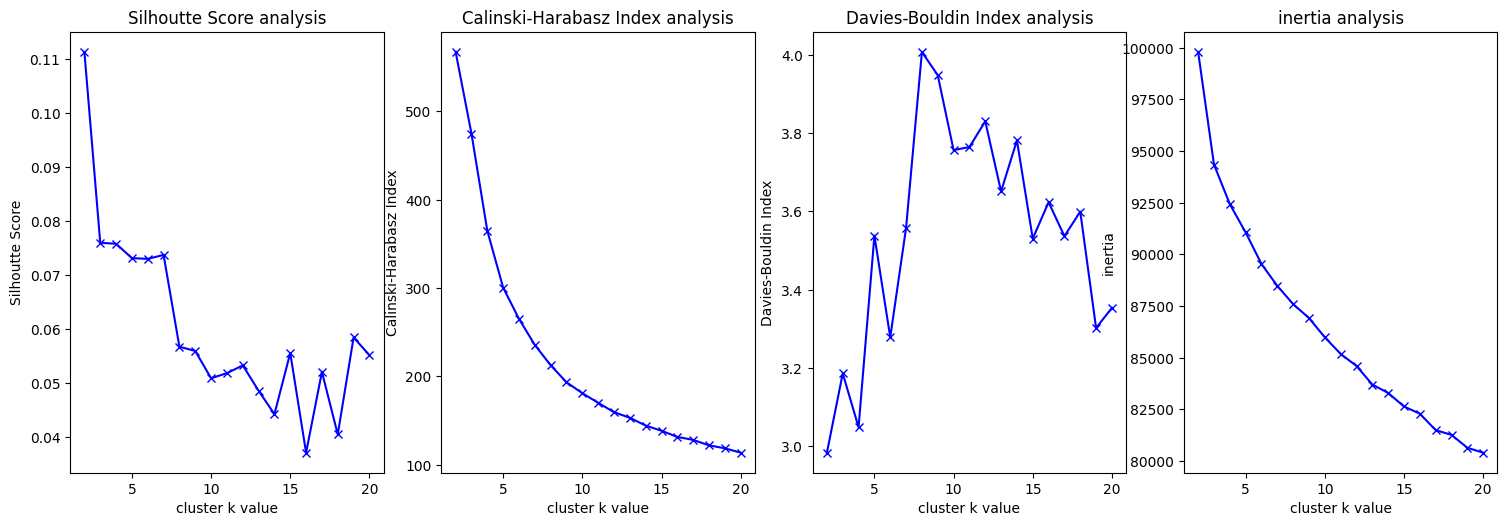

In [86]:
import numpy as np
all_MiniLM_L6_v2_embedding = np.load('data/all_MiniLM_L6_v2_embedding.npy', allow_pickle=True).item()
np_all_MiniLM_L6_v2_embedding = np.stack(list(all_MiniLM_L6_v2_embedding.values()), axis=0)
cluster_result = get_best_cluster(np_all_MiniLM_L6_v2_embedding, 2, 20)
plot_result(cluster_result, "n_cluster")

2023-04-12 22:36:41.482 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:36:43.067 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:36:44.791 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:36:46.956 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=5, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:36:49.272 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:36:51.803 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=10

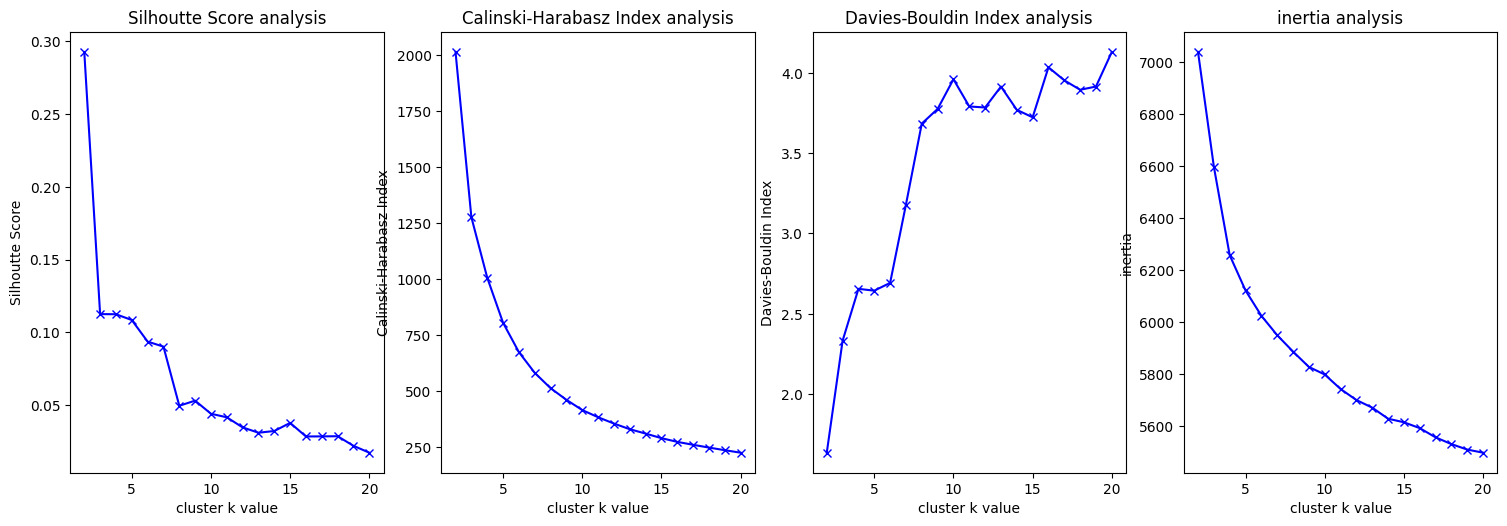

In [87]:
import numpy as np
promcse_embedding = np.load('data/promcse_embedding.npy', allow_pickle=True).item()
np_promcse_embedding = np.stack(list(promcse_embedding.values()), axis=0)
cluster_result = get_best_cluster(np_promcse_embedding, 2, 20)
plot_result(cluster_result, "n_cluster")

2023-04-12 22:37:52.038 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:37:53.591 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:37:55.551 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:37:57.775 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=5, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:38:00.244 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=42) with 6055 Datapoints.
2023-04-12 22:38:02.781 | INFO     | unsupervised_absa.clustering:fit:53 - Start clustering KMeans(max_iter=10

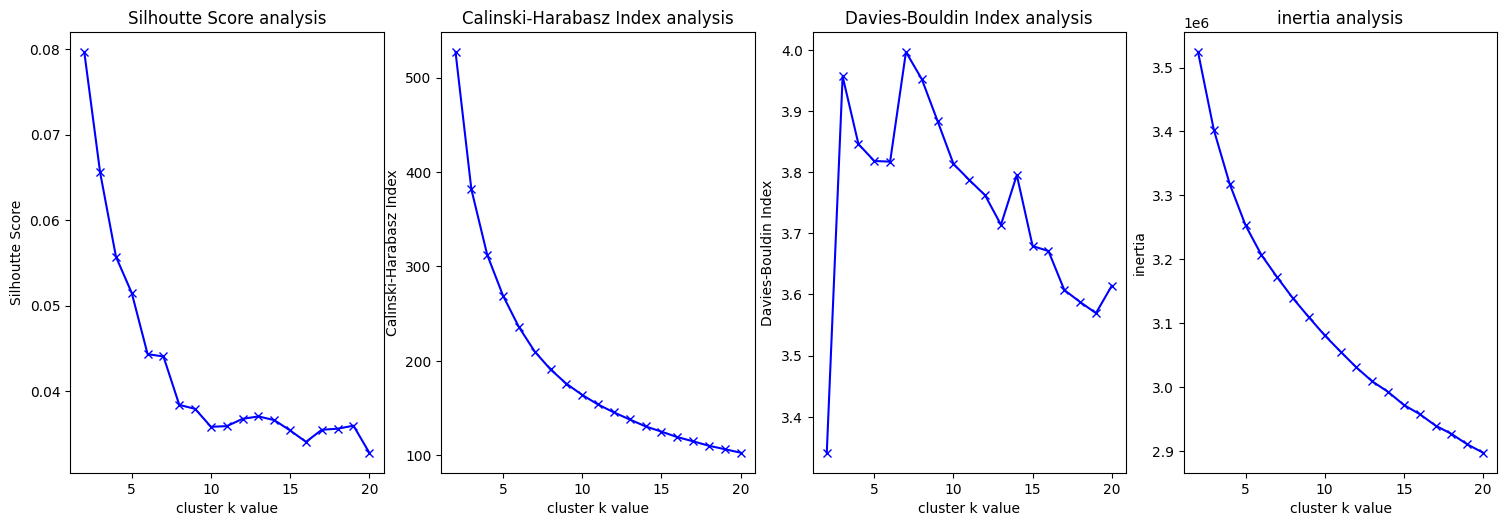

In [88]:
import numpy as np
simcse_embedding = np.load('data/simcse_embedding.npy', allow_pickle=True).item()
np_simcse_embedding = np.stack(list(simcse_embedding.values()), axis=0)
cluster_result = get_best_cluster(np_simcse_embedding, 2, 20)
plot_result(cluster_result, "n_cluster")

### Perform analysis on the clusters

Looking at the samples of each clusters that are close to the clusters and that are in between (overlapping) will be great to see how the model cluster the data points. First assumption possibility is that the model understands that the dataset are mostly restaurants and laptop reviews and split it into. If so, we need to seperate the 2 dataset and perform another clustering to see further details

# MNLI

In [1]:
from unsupervised_absa.mnli import MnliPipeline
model = MnliPipeline('microsoft/deberta-large-mnli')

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
import json
with open('data/semeval_pos_tag_filtered.json') as f:
    pos_tags = json.load(f)

In [3]:
import pandas as pd
pos_tag_df = pd.DataFrame.from_dict(pos_tags)

In [4]:
# expanding the df to sentence to 1 pos tag df
from tqdm import tqdm
import pandas as pd
new_df = {'text': [], 'sid': [], 'aspectLabel': []}
for index, row in tqdm(pos_tag_df.iterrows()):
    if len(row['pos_tag']) != 0:
        text = row['text']
        sid = row['sentenceId']
        for aspect in row['pos_tag']:
            new_df['aspectLabel'].append(aspect['word'])
            new_df['text'].append(text)
            new_df['sid'].append(sid)

mnli_df = pd.DataFrame(new_df)

6086it [00:00, 20647.84it/s]


In [11]:
dataset = model.extract_polarity(mnli_df, 'text', 'aspectLabel', device='cuda', batch_size=64)

2023-04-13 15:32:04.726 | INFO     | unsupervised_absa.mnli:extract_polarity:145 - Preprocessing dataset with length: 14228
2023-04-13 15:32:04.750 | INFO     | unsupervised_absa.mnli:extract_polarity:149 - Extracting polarity with model: microsoft/deberta-large-mnli
 65%|██████▍   | 9216/14228 [1:53:25<1:01:41,  1.35it/s]


UnboundLocalError: local variable 'e' referenced before assignment

In [8]:
stats = {'a': 5, 'b': 2}
max(stats, key=stats.get)


'a'

In [11]:
def _get_polarity_term(output: dict):
    processed = {}
    term = None
    for label, score in zip(output["labels"], output["scores"]):
        # sample: This example is negative sentiment towards staff.
        polarity, term = (
            label.replace("This example is ", "")
            .replace(" sentiment towards", "")
            .replace(".", "")
            .split()
        )
        term = term
        processed[polarity] = score
    # argmax of previously extracted polarity
    processed["polarity"] = max(processed, key=processed.get)
    processed["term"] = term
    return processed

In [12]:
_get_polarity_term({'sequence': 'But the staff was so horrible to us.', 'labels': ['This example is negative sentiment towards staff.', 'This example is positive sentiment towards staff.', 'This example is neutral sentiment towards staff.'], 'scores': [0.992158055305481, 0.004752019420266151, 0.0030899278353899717]})

{'negative': 0.992158055305481,
 'positive': 0.004752019420266151,
 'neutral': 0.0030899278353899717,
 'polarity': 'negative',
 'term': 'staff'}